# JSD APP Simplified

### import libs

In [27]:
# importing required libs
# Configuring logger
import logging
import math
import subprocess
from subprocess import PIPE, STDOUT, CalledProcessError, Popen
from typing import Generator, List, Union

import numpy as np
import pandas as pd
from scipy.spatial.distance import jensenshannon
from scipy.stats import entropy

logger = logging.getLogger(__name__)
logging.basicConfig(
    format="=== %(levelname)s === %(asctime)s === %(message)s",
    level=logging.DEBUG,
    datefmt="%Y-%m-%d %H:%M:%S",
)

## Functions 

__TO DO__:
- insert default tabix indexing func
- insert entropy calc
- insert JSD calc
- insert shifting by 1 method to entropy calc, set 0 and nan values 1 and increase others by one
-  ------

- normalization of methylation (not defined now, maybe can be added further on)


### Utils (Sum up from core.py and gpf_utils.py)

#### Define custom exceptions for specific error scenarios.

In [2]:
# Define custom exceptions for specific error scenarios.
class InputMismatchError(Exception):
    """Exception for input mismatch errors."""

    pass


class MissingInputError(Exception):
    """Exception for missing input errors."""

    pass

#### execute_command 
- func to avoid repeating the execution logic


In [3]:
def execute_command(command):
    """
    Executes a system command via subprocess and returns the output.

    Args:
    command (list): A list containing the command and its arguments.

    Returns:
    str: The output of the command or None if an error occurred.
    """
    try:
        result = subprocess.run(
            command,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True,
            check=True,
        )
        return result.stdout.strip()
    except subprocess.CalledProcessError as e:
        logger.error(f"Command '{' '.join(command)}' failed with error: {e.stderr}")
        return None

#### supremum_details 
 - getting maximum end position and the total number of sites in one func

In [4]:
def supremum_details(tabixfiles, chrom, base_path, tabix_path="tabix"):
    """
    Get the maximum end position and the total number of sites for specified chromosome and files.

    Args:
    tabixfiles (list): List of file paths.
    chrom (str): Chromosome to query.
    base_path (str): Directory path where files are located.
    tabix_path (str): Path to the tabix executable.

    Returns:
    tuple: (maximum position, total sites) or (None, None) if no valid data.
    """
    max_position = 0
    total_sites = 0
    valid_data_found = False

    for file in tabixfiles:
        full_path = f"{base_path}/{file}"
        command = [tabix_path, full_path, f"{chrom}"]
        output = execute_command(command)

        if output:
            valid_data_found = True
            lines = output.split("\n")
            positions = []
            for line in lines:
                try:
                    position = int(line.split("\t")[2])
                    positions.append(position)
                except (IndexError, ValueError) as e:
                    logger.error(f"Error processing line in file {file}: {e}")

            if positions:
                max_position = max(max_position, max(positions))
            total_sites += len(lines)

    if not valid_data_found:
        logger.warning(f"No valid data found for chromosome {chrom}.")
        return None, None

    return max_position, total_sites

#### get_regions
 - regions based on the supremum details of chromosome positions and site

In [5]:
def get_regions(
    tabixfiles, chrom, base_path="", tabix_path="tabix", exp_numsites=1e3
):  # 1e3 == 1000
    """
    Calculate regions based on the supremum details of chromosome positions and sites.

    Args:
        tabixfiles (list): List of paths to tabix-indexed files.
        chrom (str): Chromosome number.
        exp_numsites (float): Expected number of sites/data points for determining the step size.
        base_path (str): Directory containing the files.
        tabix_path (str): Path to the tabix executable.

    Returns:
        tuple: A tuple containing regions and their corresponding progress percentages, or False if data is missing.
    """

    logger.debug("Getting regions for tabix-indexed files...")
    # Retrieve the maximum position and total number of sites for the chromosome
    sup_position, sup_numsites = supremum_details(
        tabixfiles, chrom, base_path, tabix_path
    )

    if sup_position is None or sup_numsites == 0:
        logger.info("Skipping due to missing data or no entries.")
        return False

    # Calculate the step size for genomic regions
    step = math.ceil(sup_position / sup_numsites * exp_numsites)
    stepsize = min(
        step, sup_position
    )  # Ensure stepsize does not exceed the chromosome length

    # Generate start and end positions for genomic regions
    pos_start = list(range(0, sup_position, stepsize))
    pos_end = list(range(stepsize, sup_position + stepsize, stepsize))
    if pos_end:
        pos_end[-1] = min(pos_end[-1], sup_position)  # Adjust last end position

    # Calculate progress percentages and define regions
    progress = [round(100 * end / sup_position, 1) for end in pos_end]
    regions = list(zip([chrom] * len(pos_start), pos_start, pos_end))

    # logger.debug("Regions successfully retrieved with progress: %s", progress)
    return regions, progress

#### get_data

 -  Combines genomic data from tabix-indexed files based on specified regions.
 -  data columns are always the same methy+cov, can be set default
 -  join is outer as default, since we will use all the data
 -  preset is bed as default. other pssobilities are gff, sam, vcf ##### TODO with other types??

 -  labels are sample numbe
 -  
 -  reeturns DF with null values !!!
 -  Optimize data_columns
 -  

In [112]:
def get_data(
    files: List[str],
    labels: List[str] = None,
    data_columns: str = [
        list(zip(["3", "4", "5"], ["5mC", "C", "cov"], [np.int64, np.int64, np.int64]))
    ],  # from bed files
    regions: List[str] = None,
    join: str = "outer",
    preset: str = "bed",
    tabix_path: str = "tabix",
) -> Generator[pd.DataFrame, None, None]:
    """
    Combines tabix-indexed genome position files based on specified regions.

    Args:
        files: List of file paths.
        labels: List of labels for each file (optional).
        data_columns: Specific columns to include from each file (optional).
        regions: List of regions to query.
        join: Type of join operation for merging data ('outer' by default).
        preset: Preset format of files ('bed' by default).
        tabix_path: Path to the tabix executable.

    Yields:
        pd.DataFrame: Merged data for each region as a pandas DataFrame.
    """

    # Check input arguments
    if labels is None:
        keys = [
            f"unit_{i + 1}" for i in range(len(list(files)))
        ]  # deafult naming for labels; example: unit_1, unit_2 etc.
    elif len(labels) == len(list(files)):
        keys = labels
    elif len(labels) != len(files):
        raise InputMismatchError("Number of files and labels must match!")

    if data_columns is None:
        raise MissingInputError(
            "The list of data_columns must have at least one entry!"
        )
    elif len(data_columns) == len(list(files)):
        pass
    elif len(data_columns) == 1:
        data_columns = data_columns * len(list(files))
    else:
        raise InputMismatchError(
            "Data columns count must match the number of files or be a single entry!"
        )

    # Preset specific logic (example for 'bed')
    if preset == "bed":
        index = [(0, "#chrom", str), (1, "start", np.int64), (2, "end", np.int64)]
        index_col = [i[0] for i in index]
    else:
        raise NotImplementedError(f"Preset '{preset}' not currently supported.")

    # Output columns
    names = ["sampling_unit", "feature"]
    columns = index + data_columns[0]  # combine deafult output cols with bed input cols

    for region in regions:
        query = f"{region[0]}:{region[1]}-{region[2]}"  # example: 1:0-30304

        try:
            tabix_processes = [
                Popen(
                    [tabix_path, file_, query],
                    stdout=PIPE,
                    universal_newlines=True,
                    stderr=STDOUT,  # Capture errors in stdout
                )
                for file_ in files
            ]

            dframes = (
                pd.read_table(
                    proc.stdout,
                    header=None,
                    index_col=index_col,
                    comment="#",
                    usecols=[int(f[0]) for f in columns],
                    names=[f[1] for f in columns],
                    dtype={f[1]: f[2] for f in columns},
                )
                for i, proc in enumerate(tabix_processes)
            )

            merged_dframe = pd.concat(
                dframes, axis=1, keys=keys, names=names, join=join
            )

            # Close tabix processes to avoid resource leaks
            for proc in tabix_processes:
                proc.wait()

            yield merged_dframe

        except (CalledProcessError, pd.errors.ParserError) as e:
            logger.error(f"Error processing region {region}: {e}")

### JSD Calculation

#### prepare_data for JSD calculation

In [94]:
def prepare_data(data, min_samplesize=2, min_count=3):
    """
    Prepares data for JSD calculation by applying quality control filters.

    Args:
        data: A list of dataframes or a generator object producing dataframes.
              Each dataframe should have a multi-index representing samples and features.
        min_samplesize: Minimum number of non-zero counts required per sample (default: 2).
        min_count: Minimum count required for a feature to be considered (default: 3).

    Returns:
        A list of filtered DataFrames containing samples and features that
        pass the QC filters.
    """

    if isinstance(data, pd.DataFrame):
        # Handle single DataFrame case
        return prepare_data_single(data, min_samplesize, min_count)
    else:
        # Collect generator output into a list of DataFrames
        all_dataframes = []
        for df in data:
            all_dataframes.append(df)

        # Prepare data for each DataFrame and return the list
        return [
            prepare_data_single(df, min_samplesize, min_count) for df in all_dataframes
        ]


def prepare_data_single(indata, min_samplesize=2, min_count=3):
    """
    Prepares a single DataFrame for JSD calculation.

    Args:
        indata: A DataFrame with a multi-index representing samples and features.
        min_samplesize: Minimum number of non-zero counts required per sample (default: 2).
        min_count: Minimum count required for a feature to be considered (default: 3).

    Returns:
        A filtered DataFrame containing samples and features that pass the QC filters.
    """

    logger.debug("Preparing data for JSD calculation...")

    # Group by samples and calculate count per unit
    count_per_unit = indata.groupby(level=0, axis=1).sum()
    samplesize = count_per_unit.notnull().sum(axis=1)

    # Apply quality control filters
    count_filter = (count_per_unit >= min_count).any(axis=1)
    samplesize_filter = samplesize >= min_samplesize
    combined_filter = count_filter & samplesize_filter

    return indata[combined_filter]

#### Shannon Entropy / Infromation Entropy

- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html

```python
def shannon_entropy(countmatrix, axis=1, method='plug-in'):
    """Shannon entropy (in nat) of the feature frequency profile."""
    
    logger.debug("Calculating Shannon entropy...")
    
    if method == 'plug-in':
        expression = ("sum(where(prob > 0, -prob * log(prob), 0), axis={})"
                      .format(axis))
        count_distribution = countmatrix.sum(axis)[..., np.newaxis]
        prob = countmatrix / count_distribution
        entropy = ne.evaluate(expression)
        
        logger.debug("Shannon entropy calculation complete.")
        return entropy


In [ ]:
def shannon_entropy(data, axis=1):
    """
    Calculates Shannon entropy (in nats) of the feature frequency profile.

    Args:
        data: DataFrame containing count data.
        axis: Axis along which to calculate entropy (default: 1, across features).

    Returns:
        A Series containing the Shannon entropy for each sample.
    """

    logger.debug("Calculating Shannon entropy...")

    # Ensure data is non-negative (entropy is undefined for negative values)
    data = data.clip(lower=0)
    prob = data / data.sum(axis=axis, keepdims=True)

    # Calculate entropy using scipy.stats.entropy
    entropy_values = entropy(prob, axis=axis)

    logger.debug("Shannon entropy calculation complete.")
    return entropy_values

#### Jensen Shannon Divergence



- using the library from scipy:  https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.jensenshannon.html#scipy-spatial-distance-jensenshannon
- 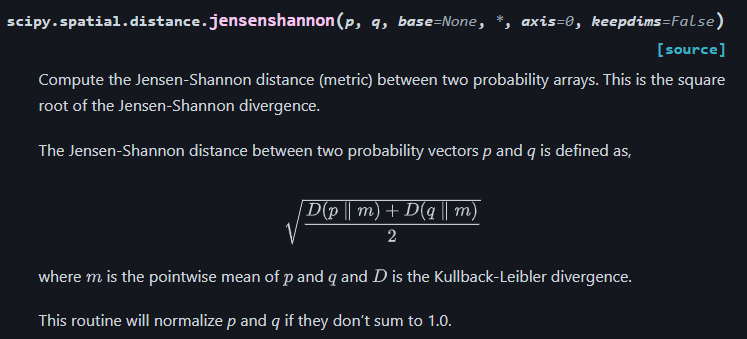

###### Prev code

```python

def js_divergence(indata, weights=None): # indata is DF with multiindex: 
    """
    """
    #print(indata)
    LOG2E = np.log2(math.e)
    
    logger.debug("Calculating count per unit...")
    # grouping by samples
    count_per_unit = indata.groupby(level=0, axis=1).sum()
    samplesize = count_per_unit.notnull().sum(axis=1)

    
    logger.debug("Applying QC filters...")
    min_samplesize = 2
    min_count = 3
    count_filter = (count_per_unit >= min_count).any(axis=1)
    samplesize_filter = (samplesize >= min_samplesize)
    combined_filter = (count_filter & samplesize_filter)
    data = indata[combined_filter]

    if data.empty:
        return data
    else:
        logger.debug("Calculating JS divergence...")
        data_unit = count_per_unit[combined_filter]
        #data_unit = 
        
        data_feature = data.groupby(level=1, axis=1).sum().astype(np.int32)
        
        counts = data.values.reshape(
            data_unit.shape[0],
            data_unit.shape[1],
            data_feature.shape[1])
        print(data_feature)
        mix_entropy = shannon_entropy(data_feature.values)
        avg_entropy = np.average(
            shannon_entropy(counts, axis=2),
            weights=(data_feature['name2'] + data_feature['name3']).fillna(0, inplace=True), #
            axis=1)

        div = data_feature
        div.insert(0, 'JSD_bit_', LOG2E * (mix_entropy - avg_entropy))
        div.insert(1, 'sample size', samplesize[combined_filter])
        div.insert(2, 'HMIX_bit_', LOG2E * mix_entropy)

        logger.debug("JS divergence calculation complete.")
        
        return div

In [29]:
def js_divergence(data_unit, data_feature, weights=None):
    """
    Calculates Jensen-Shannon divergence between two probability distributions.

    Args:
        data_unit: DataFrame containing count data for one unit (e.g., sample).
        data_feature: DataFrame containing total counts for each feature.
        weights: Optional weights for averaging entropy calculations (default: None).

    Returns:
        A DataFrame containing JSD, average entropy, mixed entropy, sample size,
        and HMIX (mixed entropy in bits) for each feature.
    """

    logger.debug("Calculating JS divergence...")

    # Ensure data is non-negative (JSD is undefined for negative values)
    data_unit = data_unit.clip(lower=0)
    data_feature = data_feature.clip(lower=0)

    # Calculate probabilities
    prob_unit = data_unit / data_unit.sum(axis=1, keepdims=True)
    prob_feature = data_feature / data_feature.sum()

    # Calculate mixed entropy using scipy.stats.entropy
    mix_entropy = entropy(prob_feature, axis=1)

    # Calculate average entropy using weights (if provided)
    if weights is None:
        avg_entropy = np.average(entropy(prob_unit, axis=2), axis=1)
    else:
        avg_entropy = np.average(entropy(prob_unit, axis=2), weights=weights, axis=1)

    # Calculate JSD
    jsd = jensenshannon(prob_feature.T, prob_unit.mean(axis=0))

    # Create output DataFrame with additional information
    div = pd.DataFrame(
        {
            "JSD_bit": jsd,
            "sample size": data_unit.shape[0],
            "HMIX_bit": mix_entropy,
        }
    )

    # Add average entropy if weights were provided
    if weights is not None:
        div["Avg Entropy_bit"] = avg_entropy

    logger.debug("JS divergence calculation complete.")
    return div

## TESTING

### Test Utils

#### define path for tabix (should work in the environment??)

__TO FIX!__

In [22]:
##### TESTING PURPOSE ######

tabix_path = "/home/eharpu/data/conda/envs/environment_shannon/bin/tabix"
base_path = "/home/eharpu/shannon"
bedgraph_file = "/home/eharpu/shannon/SRR017256_CHG.bedGraph.gz"
region = "1"
chromosome = "1"
bedgraph_files = ["SRR017256_CHG.bedGraph.gz"]

#### Test for supremum_details 

In [106]:
max_pos, num_sites = supremum_details(bedgraph_files, chromosome, base_path, tabix_path)
print(f"Maximum Position: {max_pos}")
print(f"Total Number of Sites: {num_sites}")

Maximum Position: 30427532
Total Number of Sites: 1004088


#### Test regions, progress

In [107]:
regions, progress = get_regions(
    bedgraph_files, chromosome, base_path=base_path, tabix_path=tabix_path
)
print("Regions:", regions[:5])
print("Progress:", progress[:5])

=== DEBUG === 2024-04-19 13:39:14 === Getting regions for tabix-indexed files...


Regions: [('1', 0, 30304), ('1', 30304, 60608), ('1', 60608, 90912), ('1', 90912, 121216), ('1', 121216, 151520)]
Progress: [0.1, 0.2, 0.3, 0.4, 0.5]


#### Test get_data

In [116]:
labels = [i.split("_")[0] for i in bedgraph_files]

# gpf_data = [list(zip(["4", "5", "6"], ["m", "dm", "cov"], [np.int32, np.int32,np.int32]))]
indata = get_data(bedgraph_files, labels, regions=regions, tabix_path=tabix_path)
total_record = 0

for region_data in get_data(
    bedgraph_files, labels, regions=regions, tabix_path=tabix_path
):
    total_record += len(region_data)
    # print(region_data)

print(total_record)

1004123


### Test JSD 

#### prepare_data

In [117]:
prepared_data = prepare_data(indata)

=== DEBUG === 2024-04-19 13:44:05 === Preparing data for JSD calculation...
/sctmp/eharpu/ipykernel_2311874/4039529007.py:44: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  count_per_unit = indata.groupby(level=0, axis=1).sum()
=== DEBUG === 2024-04-19 13:44:05 === Preparing data for JSD calculation...
/sctmp/eharpu/ipykernel_2311874/4039529007.py:44: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  count_per_unit = indata.groupby(level=0, axis=1).sum()
=== DEBUG === 2024-04-19 13:44:05 === Preparing data for JSD calculation...
/sctmp/eharpu/ipykernel_2311874/4039529007.py:44: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  count_per_unit = indata.groupby(level=0, axis=1).sum()
=== DEBUG === 2024-04-19 13:44:05 === Preparing data for JSD calculation...
/sctmp/eharpu/ipykernel_2311874/4039529007.py:44: F

In [118]:
prepared_data

[Empty DataFrame
 Columns: [(SRR017256, 5mC), (SRR017256, C), (SRR017256, cov)]
 Index: [],
 Empty DataFrame
 Columns: [(SRR017256, 5mC), (SRR017256, C), (SRR017256, cov)]
 Index: [],
 Empty DataFrame
 Columns: [(SRR017256, 5mC), (SRR017256, C), (SRR017256, cov)]
 Index: [],
 Empty DataFrame
 Columns: [(SRR017256, 5mC), (SRR017256, C), (SRR017256, cov)]
 Index: [],
 Empty DataFrame
 Columns: [(SRR017256, 5mC), (SRR017256, C), (SRR017256, cov)]
 Index: [],
 Empty DataFrame
 Columns: [(SRR017256, 5mC), (SRR017256, C), (SRR017256, cov)]
 Index: [],
 Empty DataFrame
 Columns: [(SRR017256, 5mC), (SRR017256, C), (SRR017256, cov)]
 Index: [],
 Empty DataFrame
 Columns: [(SRR017256, 5mC), (SRR017256, C), (SRR017256, cov)]
 Index: [],
 Empty DataFrame
 Columns: [(SRR017256, 5mC), (SRR017256, C), (SRR017256, cov)]
 Index: [],
 Empty DataFrame
 Columns: [(SRR017256, 5mC), (SRR017256, C), (SRR017256, cov)]
 Index: [],
 Empty DataFrame
 Columns: [(SRR017256, 5mC), (SRR017256, C), (SRR017256, cov)]
